In [53]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import pandas as pd

In [54]:
import os

file_path = os.path.join("..", "embeds", "vox2_eval", "campplus_embeddings.parquet")

df = pd.read_parquet(file_path)


df.head()

,path,person_id,utterance_filename,embedding
0,../data/vox2_eval\id00017\102.wav,id00017,102.wav,"[-0.7678354, -0.33199775, 0.12474791, 0.002808..."
1,../data/vox2_eval\id00017\105.wav,id00017,105.wav,"[-1.2302246, -0.3015075, -0.5216784, -0.101753..."
2,../data/vox2_eval\id00017\109.wav,id00017,109.wav,"[-0.7361372, -0.16196367, 0.23993516, 0.299446..."
3,../data/vox2_eval\id00017\111.wav,id00017,111.wav,"[-0.4993775, -0.30907992, 1.1163626, 0.6655525..."
4,../data/vox2_eval\id00017\112.wav,id00017,112.wav,"[-0.93947625, -0.31775174, 0.93463063, 0.30146..."


In [55]:
# df['embedding'] = df['embedding'].apply(lambda x: np.array(x.strip('[]').split(), dtype=float))
# df.head()

In [56]:
# Check dimensions of all embeddings
df["embedding_length"] = df["embedding"].apply(len)
print(df["embedding_length"].value_counts())

embedding_length
512    2487
Name: count, dtype: int64


In [57]:
def cosine_similarity(e1, e2):
    cosine_score = torch.dot(e1, e2) / (torch.norm(e1) * torch.norm(e2))
    cosine_score = cosine_score.item()
    return (cosine_score + 1.0) / 2  # normalize: [-1, 1] => [0, 1]


def cosine_sim(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:

    tensor1_normalized = tensor1 / torch.norm(tensor1, dim=1, keepdim=True)
    tensor2_normalized = tensor2 / torch.norm(tensor2, dim=1, keepdim=True)

    cosine_similarity_matrix = torch.mm(tensor1_normalized, tensor2_normalized.T)

    normalized_similarity_matrix = (cosine_similarity_matrix + 1.0) / 2.0

    return normalized_similarity_matrix

In [58]:
embeddings = df["embedding"].values
embeddings_array = np.vstack(embeddings)
embeddings_tensor = torch.tensor(embeddings_array, dtype=torch.float32)

In [59]:
# embeddings is a array of array of floats i want to compute a matrix of cosine similarity each element of the matrix is the cosine similarity between the two embeddings
# using torch for this

similarity_matrix = cosine_sim(embeddings_tensor, embeddings_tensor)
# fill the diagonal with

In [60]:
similarity_matrix.shape

torch.Size([2487, 2487])

In [61]:
labels = df["person_id"].values

In [62]:
labels_matrix = np.equal(labels[:, None], labels)
np.fill_diagonal(labels_matrix, False)
upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
class_labels = labels_matrix[upper_triangle_indices]
scores = similarity_matrix[upper_triangle_indices]

In [63]:
print("class_labels", class_labels, "len", len(class_labels))
print("scores", scores, "len", len(scores))

class_labels [ True  True  True ...  True  True  True] len 3091341
scores tensor([0.9032, 0.9128, 0.8848,  ..., 0.9184, 0.9592, 0.8893]) len 3091341


In [64]:
genuine_scores = scores[class_labels]
impostor_scores = scores[~class_labels]

In [65]:
genuine_scores.shape, impostor_scores.shape

(torch.Size([60691]), torch.Size([3030650]))

In [66]:
# Combine scores and generate thresholds
thresholds = np.linspace(0, 1, 1000)  # Cosine similarity ranges from -1 to 1
FAR = []  # False Acceptance Rate
FRR = []  # False Rejection Rate

for threshold in thresholds:
    # FAR: Proportion of impostor scores >= threshold
    FAR.append(np.mean(np.array(impostor_scores) >= threshold))

    # FRR: Proportion of genuine scores < threshold
    FRR.append(np.mean(np.array(genuine_scores) < threshold))

# Find the threshold where FAR and FRR are equal (EER)
EER_index = np.argmin(np.abs(np.array(FAR) - np.array(FRR)))
EER = (FAR[EER_index] + FRR[EER_index]) / 2
EER_threshold = thresholds[EER_index]

print(f"EER: {EER:.4f} at threshold: {EER_threshold:.4f}")

EER: 0.0139 at threshold: 0.6627


In [67]:
import matplotlib.pyplot as plt

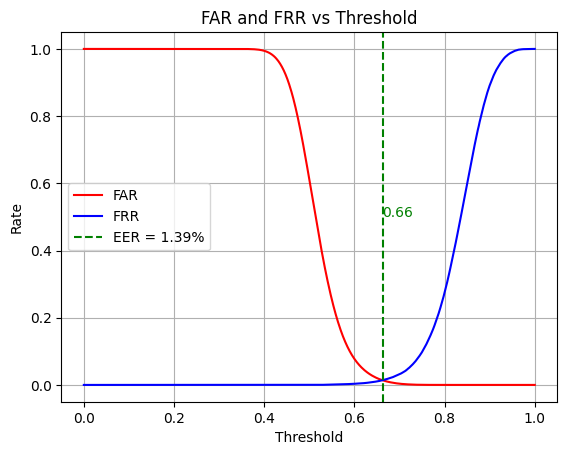

In [68]:
plt.plot(thresholds, FAR, label="FAR", color="red")
plt.plot(thresholds, FRR, label="FRR", color="blue")
plt.axvline(
    EER_threshold, color="green", linestyle="--", label=f"EER = {EER * 100:.2f}%"
)
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("FAR and FRR vs Threshold")
plt.legend()
plt.grid()

# Annotate the EER threshold
plt.text(EER_threshold, 0.5, f"{EER_threshold:.2f}", color="green")

plt.show()

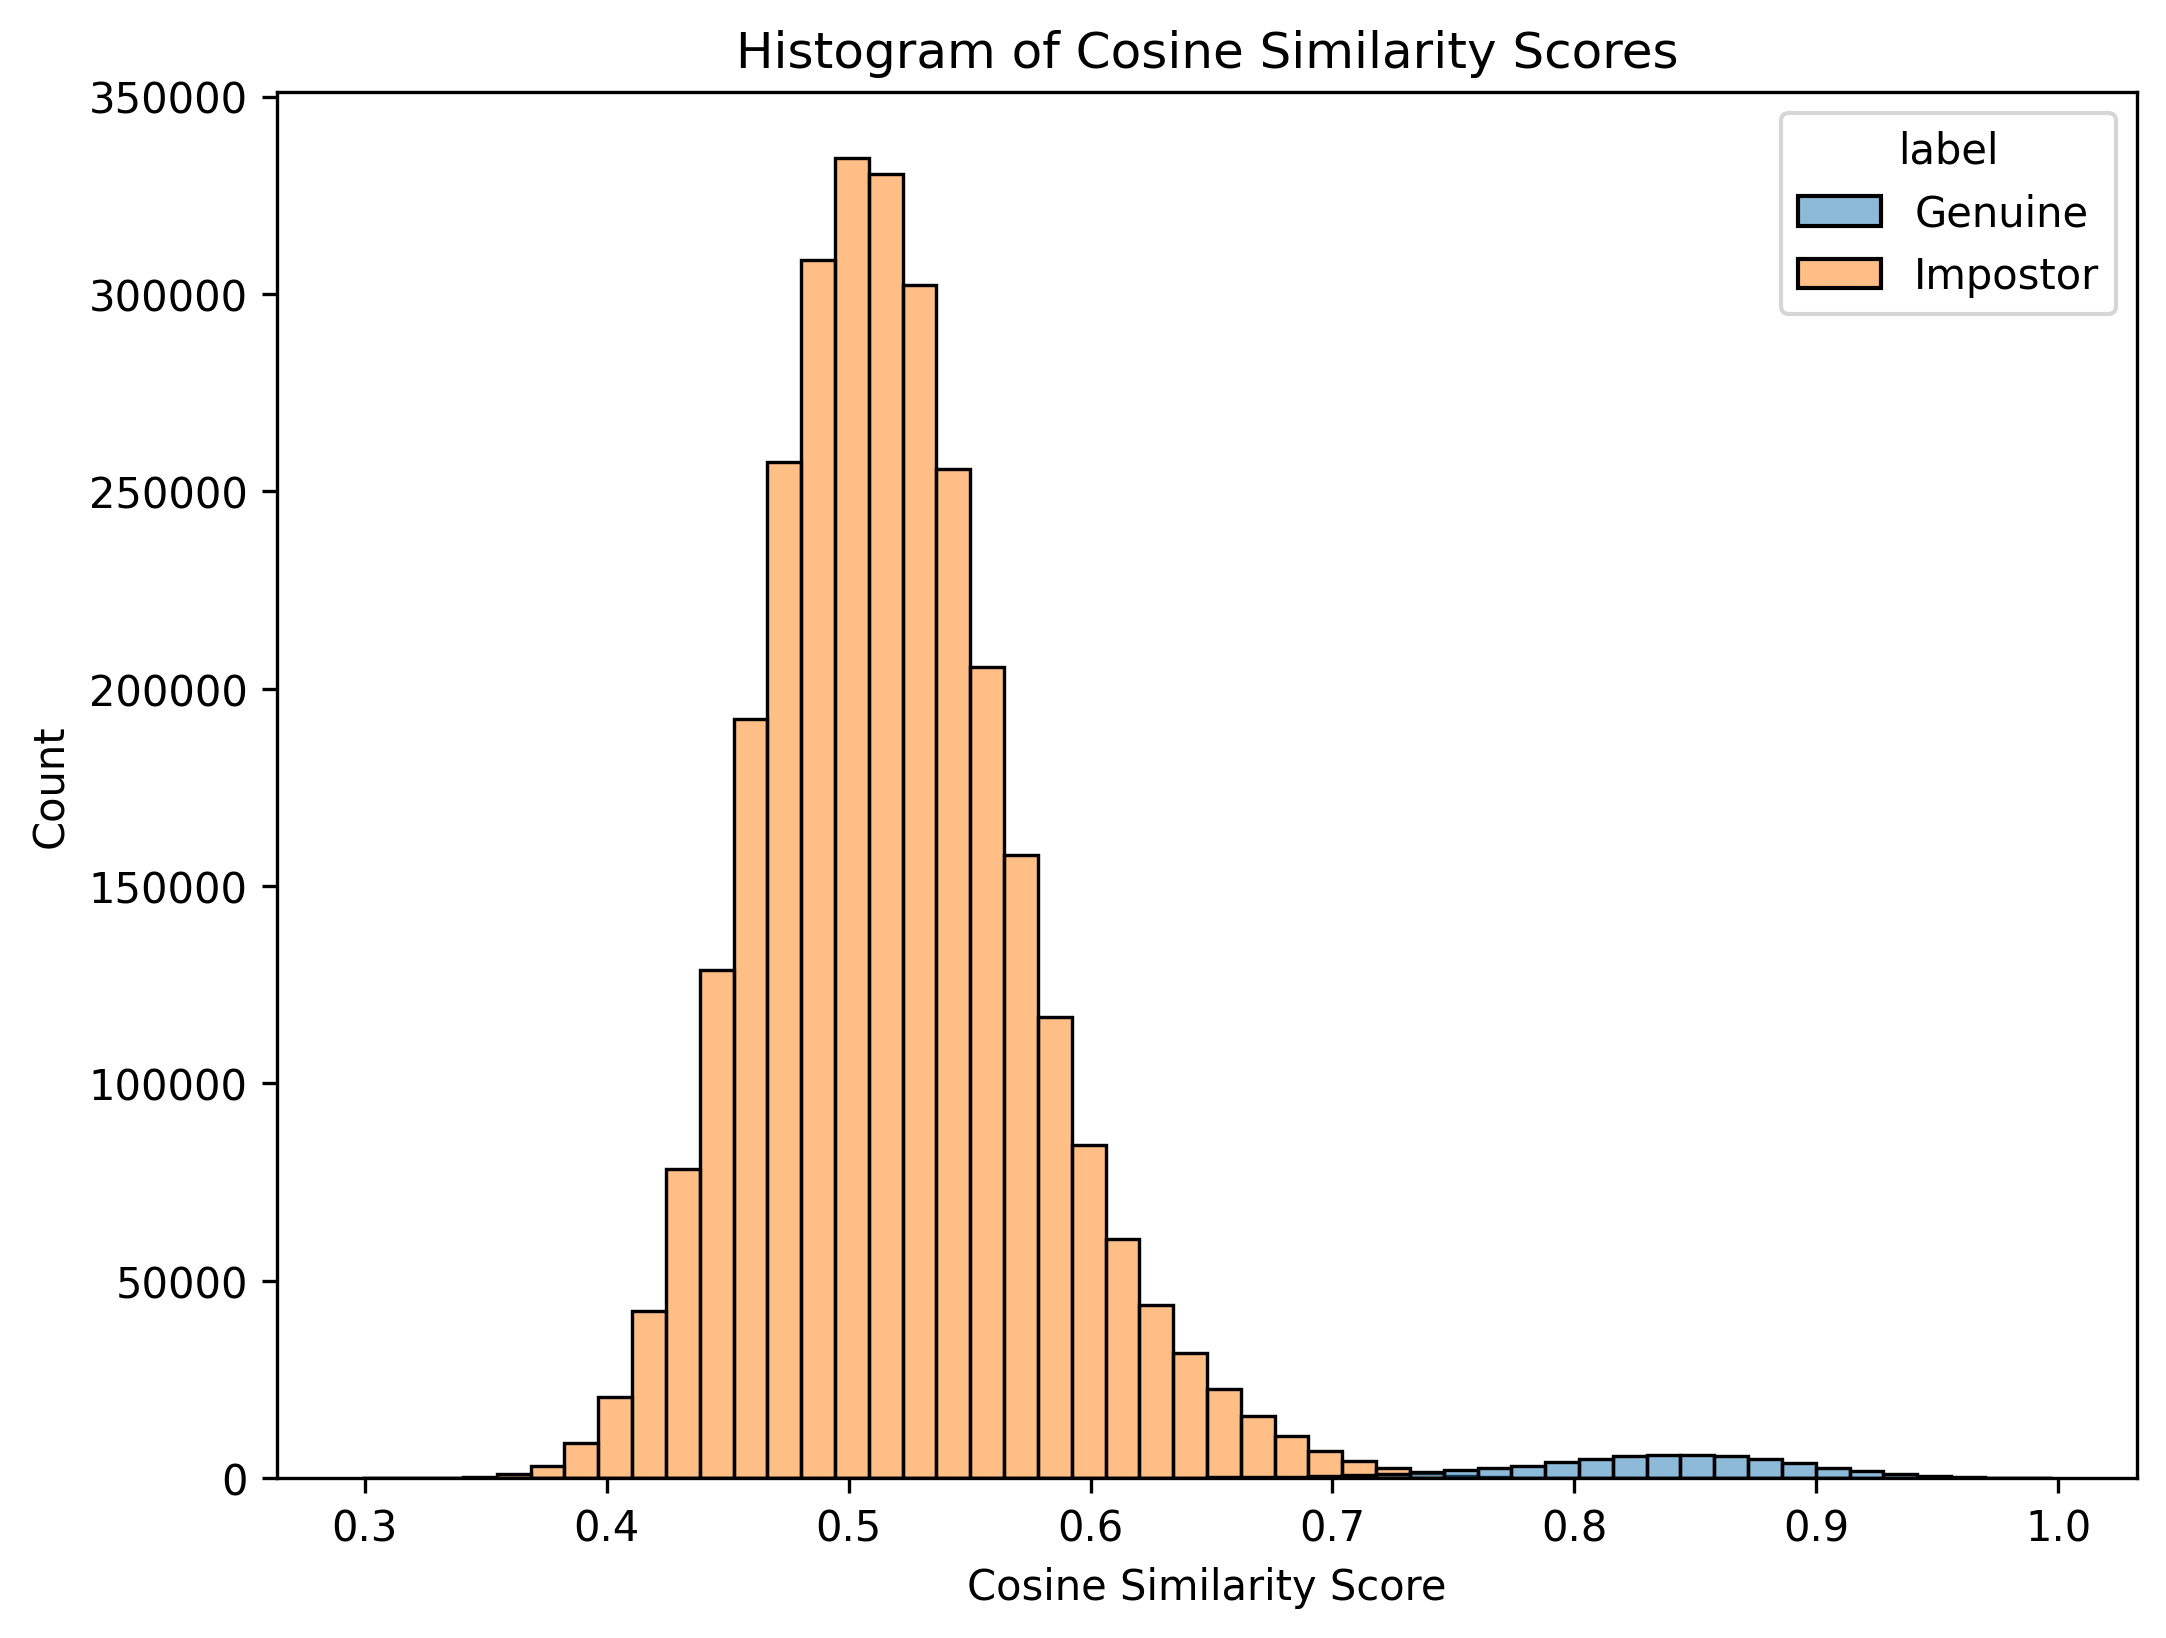

In [69]:
import seaborn as sns

# Create a DataFrame for plotting
scores_df = pd.DataFrame(
    {
        "Score": np.concatenate([genuine_scores, impostor_scores]),
        "label": ["Genuine"] * len(genuine_scores)
        + ["Impostor"] * len(impostor_scores),
    }
)

# Plot the normalized histogram with higher dpi
plt.figure(figsize=(8, 6), dpi=300)
sns.histplot(data=scores_df, x="Score", hue="label", kde=False, bins=50, alpha=0.5)
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Count")
plt.title("Histogram of Cosine Similarity Scores")
plt.show()